In [1]:
pip install pandas numpy matplotlib tensorflow


You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


2024-10-01 08:23:32.036456: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 08:23:32.038719: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 08:23:32.042864: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 08:23:32.055254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 08:23:32.076894: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()
 
table_name = '"FACT_CUSTOMER_ORDERS"'
 
sf_df = my_session.sql("select * from {}".format(table_name))
df = sf_df.to_pandas()

In [4]:
df = df[['PRODUCT_ID','ORDER_DATE','ORDER_QTY']]

In [5]:
df['ORDER_DATE']=pd.to_datetime(df['ORDER_DATE'])

In [6]:
df = df.sort_values('ORDER_DATE')

In [15]:
# Normalize the ORDER_QTY
scaler = MinMaxScaler(feature_range=(0, 1))
df['ORDER_QTY'] = scaler.fit_transform(df[['ORDER_QTY']])

# Create a new DataFrame with only the ORDER_QTY column
data = df[['ORDER_QTY']].values

# Split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [16]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
151125/151125 - 155s - 1ms/step - loss: 0.0930
Epoch 2/5
151125/151125 - 154s - 1ms/step - loss: 0.0926
Epoch 3/5
151125/151125 - 153s - 1ms/step - loss: 0.0926
Epoch 4/5
151125/151125 - 154s - 1ms/step - loss: 0.0925
Epoch 5/5
151125/151125 - 154s - 1ms/step - loss: 0.0925


In [17]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(np.mean((trainPredict[:, 0] - trainY[0]) ** 2))
testScore = np.sqrt(np.mean((testPredict[:, 0] - testY[0]) ** 2))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')


4723/4723 ━━━━━━━━━━━━━━━━━━━━ 4s 853us/step
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 2s 832us/step
Train Score: 0.31 RMSE
Test Score: 0.30 RMSE


In [18]:
# Forecast the next 25 months
last_value = data[-look_back:]
predictions = []

for _ in range(25):
    last_value = np.reshape(last_value, (1, 1, look_back))
    next_value = model.predict(last_value)
    predictions.append(next_value[0, 0])
    last_value = np.append(last_value[:, :, 1:], next_value, axis=2)

# Invert predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame for the predictions
future_dates = pd.date_range(start=df['ORDER_DATE'].max(), periods=25, freq='M')
forecast_df = pd.DataFrame(predictions, index=future_dates, columns=['FORECAST_QTY'])

# Display the forecasted data
print(forecast_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [9]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(np.mean((trainPredict[:, 0] - trainY[0]) ** 2))
testScore = np.sqrt(np.mean((testPredict[:, 0] - testY[0]) ** 2))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')


4723/4723 ━━━━━━━━━━━━━━━━━━━━ 4s 859us/step
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 2s 809us/step
Train Score: 288.80 RMSE
Test Score: 288.58 RMSE


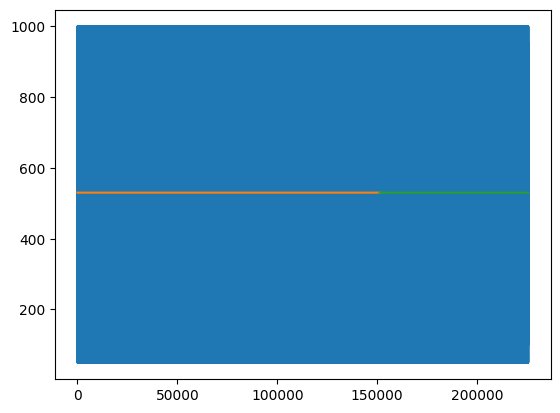

In [10]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(data) - 1, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [12]:
# Forecast the next 25 months
last_value = data[-look_back:]
predictions = []

for _ in range(25):
    last_value = np.reshape(last_value, (1, 1, look_back))
    next_value = model.predict(last_value)
    predictions.append(next_value[0, 0])
    last_value = np.append(last_value[:, :, 1:], next_value, axis=2)

# Invert predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame for the predictions
future_dates = pd.date_range(start=df['ORDER_DATE'].max(), periods=25, freq='M')
forecast_df = pd.DataFrame(predictions, index=future_dates, columns=['FORECAST_QTY'])

# Plot the results
plt.plot(df['ORDER_DATE'], scaler.inverse_transform(data), label='Actual')
plt.plot(forecast_df.index, forecast_df['FORECAST_QTY'], label='Forecast')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [13]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(np.mean((trainPredict[:, 0] - trainY[0]) ** 2))
testScore = np.sqrt(np.mean((testPredict[:, 0] - testY[0]) ** 2))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')


4723/4723 ━━━━━━━━━━━━━━━━━━━━ 4s 864us/step
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 2s 808us/step


ValueError: Found array with dim 3. None expected <= 2.

In [14]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(np.mean((trainPredict[:, 0] - trainY[0]) ** 2))
testScore = np.sqrt(np.mean((testPredict[:, 0] - testY[0]) ** 2))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')


4723/4723 ━━━━━━━━━━━━━━━━━━━━ 4s 841us/step
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 2s 818us/step


ValueError: Found array with dim 3. None expected <= 2.

In [19]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(np.mean((trainPredict[:, 0] - trainY[0]) ** 2))
testScore = np.sqrt(np.mean((testPredict[:, 0] - testY[0]) ** 2))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')


4723/4723 ━━━━━━━━━━━━━━━━━━━━ 4s 837us/step
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 2s 818us/step


ValueError: Found array with dim 3. None expected <= 2.